In [1]:
#load the pth model from the current directory
import torch    
from torchvision import transforms
from torchvision.transforms import ToTensor, RandomCrop

from matplotlib import pyplot as plt
from Scaled_KAN import FastKAN
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from avalanche.benchmarks.datasets.dataset_utils import default_dataset_location
from avalanche.benchmarks import nc_benchmark

train_transform = transforms.Compose(
    [
        RandomCrop(28, padding=4),
        ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Normalise MNIST dataset
    ]
)
test_transform = transforms.Compose(
    [ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

mnist_train = MNIST(
    root=default_dataset_location("mnist"),
    train=True,
    download=True,
    transform=train_transform,
)
mnist_test = MNIST(
    root=default_dataset_location("mnist"),
    train=False,
    download=True,
    transform=test_transform,
)

loaders = {
    "train": DataLoader(mnist_train, batch_size=64, shuffle=True),
    "test": DataLoader(mnist_test, batch_size=64, shuffle=False),
}

In [3]:
#########################
# CONVENTIONAL LEARNING #
#########################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FastKAN(
                layers_hidden=[784,64,128,10],
                num_grids=8,
                device=device
            )


optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

loss_fn = torch.nn.CrossEntropyLoss()

def train(epoch):
    # Set the model in training mode
    model.train()

    # Iterate over the training data
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        # Move data to cuda
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        output = model(data)
            
        loss = loss_fn(output, target)
        loss.backward()

        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)}]")

def test():
    with torch.no_grad():
        model.eval()
        
        test_loss = 0
        correct = 0

        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(loaders["test"].dataset)
        print(
            "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                test_loss,
                correct,
                len(loaders["test"].dataset),
                100.0 * correct / len(loaders["test"].dataset),
            )
        )
        
for epoch in range(1, 5):
    train(epoch)
    test()

torch.save(model.state_dict(), "FastKAN_0_8M.pth")


Train Epoch: 1 [0/60000]
Train Epoch: 1 [6400/60000]
Train Epoch: 1 [12800/60000]
Train Epoch: 1 [19200/60000]
Train Epoch: 1 [25600/60000]
Train Epoch: 1 [32000/60000]
Train Epoch: 1 [38400/60000]
Train Epoch: 1 [44800/60000]
Train Epoch: 1 [51200/60000]
Train Epoch: 1 [57600/60000]

Test set: Average loss: 0.0134, Accuracy: 7364/10000 (74%)

Train Epoch: 2 [0/60000]
Train Epoch: 2 [6400/60000]
Train Epoch: 2 [12800/60000]
Train Epoch: 2 [19200/60000]
Train Epoch: 2 [25600/60000]
Train Epoch: 2 [32000/60000]
Train Epoch: 2 [38400/60000]
Train Epoch: 2 [44800/60000]
Train Epoch: 2 [51200/60000]
Train Epoch: 2 [57600/60000]

Test set: Average loss: 0.0086, Accuracy: 8313/10000 (83%)

Train Epoch: 3 [0/60000]
Train Epoch: 3 [6400/60000]
Train Epoch: 3 [12800/60000]
Train Epoch: 3 [19200/60000]
Train Epoch: 3 [25600/60000]
Train Epoch: 3 [32000/60000]
Train Epoch: 3 [38400/60000]
Train Epoch: 3 [44800/60000]
Train Epoch: 3 [51200/60000]
Train Epoch: 3 [57600/60000]

Test set: Average loss

In [85]:
# ######################
# # CONTINUAL LEARNING #
# ######################

# # for img, label in mnist_train:
# benchmark = nc_benchmark(
#     train_dataset=mnist_train, test_dataset=mnist_test, n_experiences=10,
#     task_labels=False, seed=1234, fixed_class_order=[0,1,2,3,4,5,6,7,8,9]
# )


# for experience in benchmark.train_stream:
#     zeros = torch.stack([img[0][0] for img in experience.dataset])
#     break
# print(zeros.shape)

torch.Size([5923, 28, 28])


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FastKAN(
                layers_hidden=[784,1569,10],
                num_grids=4,
                device=device
            )

model.load_state_dict(torch.load('FastKAN_4_6M.pth'))
model.eval()
print(model)

layers = []
for layer in model.modules():
    layers.append(layer)
layer = layers[1]
# print("====> Layer ", layer[1].output_dim)
# # # for i in range(layer.input_dim):
# for j in range(layer[1].output_dim):
#     # layer.set_curve(i, j, torch.tensor([0.0, 1.0, 0.0], device=device))
#     x, y = layer.plot_curve(0, j, num_pts=100, num_extrapolate_bins=3)
#     plt.plot(x.to('cpu').numpy(), y.to('cpu').numpy(), label=f"Last Layer, Input 0, Output {j}")
# # plt.legend()
# plt.show()

FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=3136, out_features=128, bias=False)
      (base_linear): Linear(in_features=784, out_features=128, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=512, out_features=10, bias=False)
      (base_linear): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)


In [9]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import numpy as np

# Assuming layer[1].plot_curve is a function that takes two arguments and returns x, y coordinates
def plot_curve_with_slider(j):
    x, y = layer[1].plot_curve(0, j, num_pts=100, num_extrapolate_bins=3)
    plt.figure()
    plt.plot(x.to('cpu').numpy(), y.to('cpu').numpy(), label=f"Last Layer, Input 0, Output {j}")
    plt.legend()
    plt.show()

# Create an interactive slider
interactive_plot = interactive(plot_curve_with_slider, j=widgets.IntSlider(min=0, max=9, step=1, value=1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(IntSlider(value=1, description='j', max=9), Output(layout=Layout(height='350px'))), _dom…

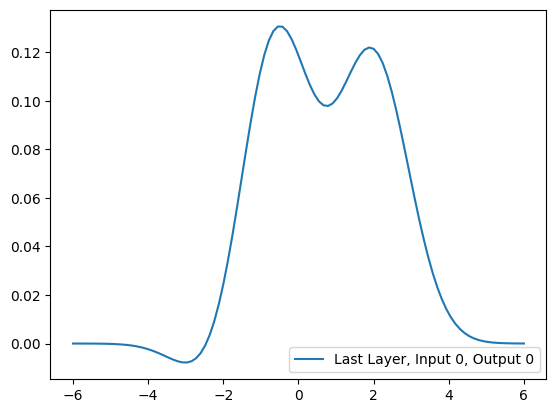

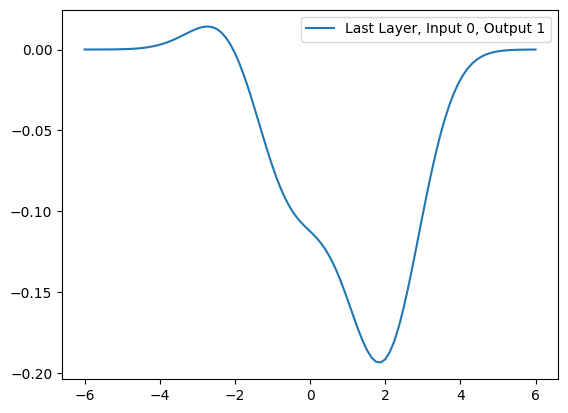

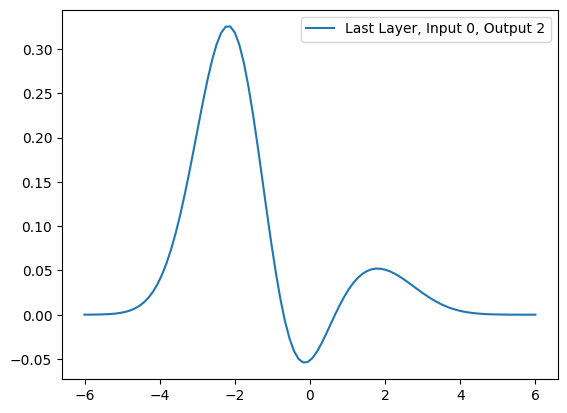

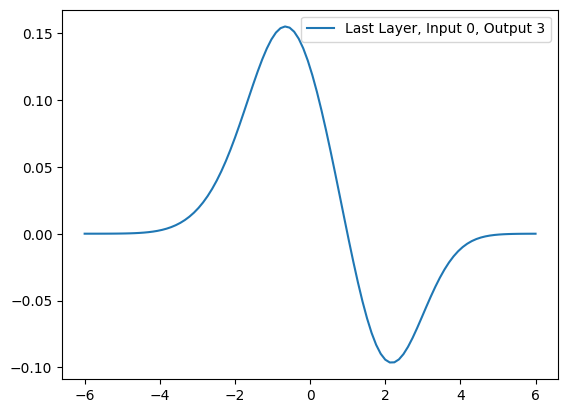

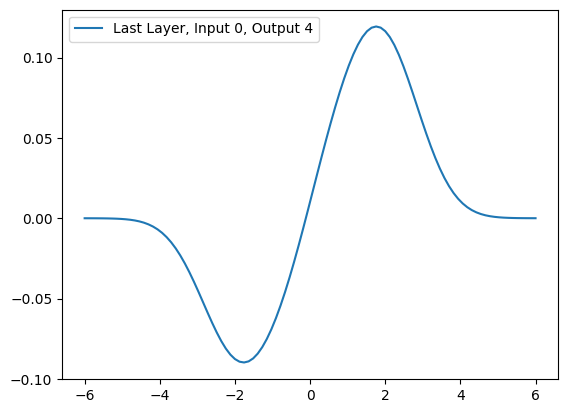

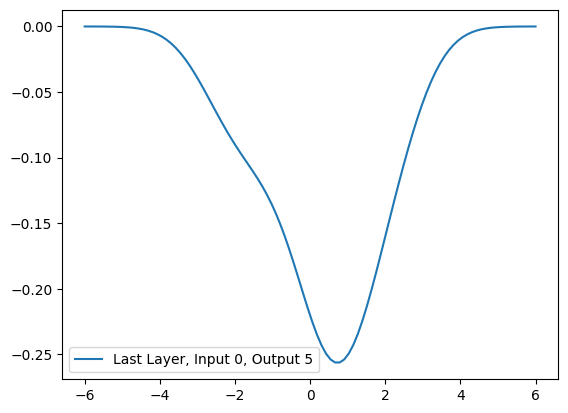

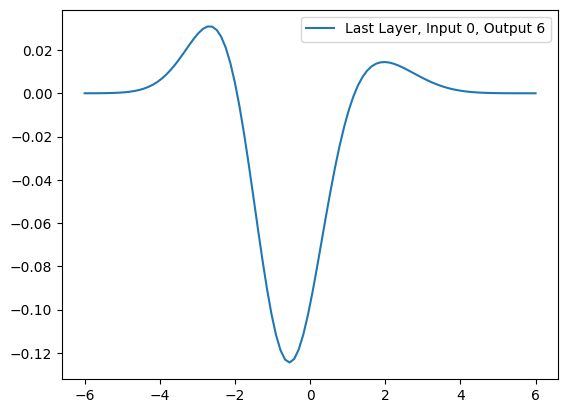

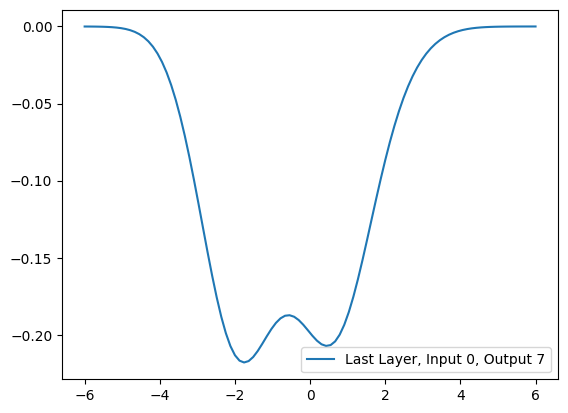

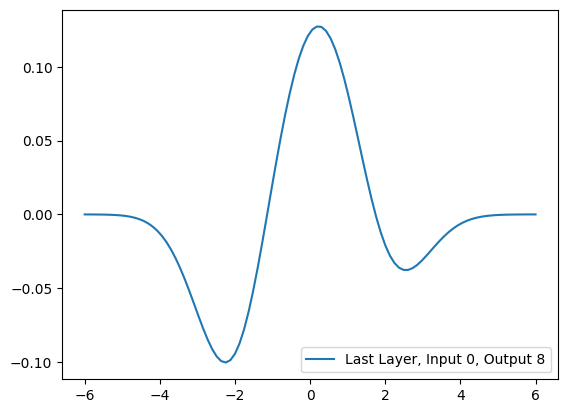

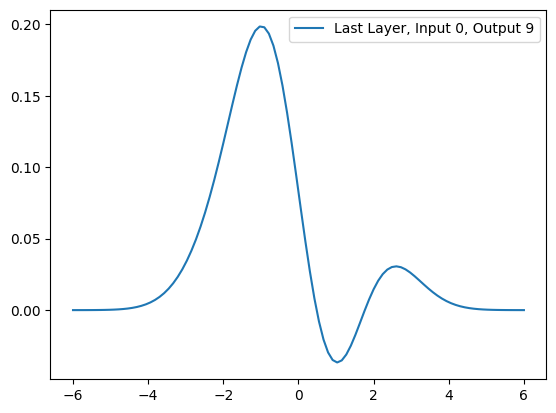

In [6]:
import os
os.chdir("../plots")
for j in range(10):
    x, y = layer[1].plot_curve(0, j, num_pts=100, num_extrapolate_bins=3)
    plt.figure()
    plt.plot(x.to('cpu').numpy(), y.to('cpu').numpy(), label=f"Last Layer, Input 0, Output {j}")
    plt.legend()
    plt.savefig(f"Output_Layer{j}.png")
os.chdir("../Custom-Benchmarks")
plt.show()